# An examination of region shape on `srcflux` source properties

As part of an evaluation of the capabilities of [PSU's ACIS Extract](http://personal.psu.edu/psb6/TARA/AE.html) package (AE), we want to evaluate how the choice of source regions (apertures) affects the source properties.

As is noted in the PSU docs (ref), due to the shape of the PSF, as the size of the region increases, the more background is included leading to a lower source significance.  However, as the size of the regions decreases, the source counts decrease, thus increasing the statistical uncertainty. This leads to the conjecture that there is some truly _optimal_ source region.

The region used by AE is a polygon which encloses ~90% of the PSF at 1.5 kev (TBR).  The region used by `srcflux` is a circle that is supposed to enclose ~90% of the PSF at 1.0keV. 

A quick visual inspection shows the AE polygons are nearly elliptical.  


Output files
	zzz_contr.contr	 : Contour Region
	zzz_contr.ellps	 : Ellipse Region
	zzz_contr.crcl 	 : Circle Region

ds9 zzz_contr.smpsf -region color green -region zzz_contr.contr \
            -region color magenta -region zzz_contr.ellps \
            -region color yellow -region zzz_contr.crcl


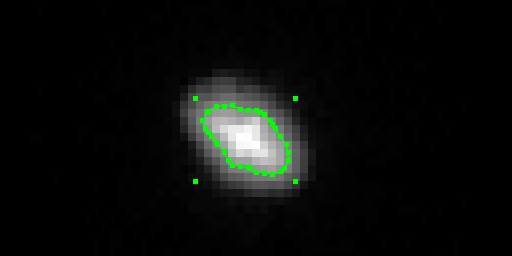

In [51]:
contour_psf  acisf4396_broad_thresh.img zzz_contr 83.7407253593 -5.3978863791

ds9 zzz_contr.smpsf -region color green -region zzz_contr.contr \
   -region select all -height 256 -width 512 \
   -scale log -zoom to 8 -view colorbar no -saveimage png psf_poly.png -exit
   
display < psf_poly.png

Therefore, rather than use the AE-like polygon, we use an ellipse that encloses 90% of the PSF 1.56 keV.  We determine the ellipse parameters by taking data from the CSC 2.0 catalog.

In this notebook we examine the results of running `srcflux` with the default circular regions (_baseline_), and with the 90% PSF ellipses.

We choose a crowded region, Orion (OBS_ID 4396, 170ksec), and used the source positions from CSC2.0.  

# Setup


## Data Preparation

We follow standard procedure to download, reprocess, and create images.

In [ ]:
ciaover -v

In [ ]:
download_chandra_obsid 4396 --exclude evt2,osol,adat,eph1,vvref --quiet

In [ ]:
chandra_repro 4396 out= clob+ verb=0

In [ ]:
fluximage 4396 out=acisf4396 bin=1 band=broad psfecf=0.9 clob+ verb=0

## Download Catalog

Originally we tried this exercise by running `wavdetect` to create a source list, but due to the crowded field the detections were sub-optimal (missed sources, detecting multiple sources as 1, etc) without additional parameter tuning.

So instead we decided to use the sources identified by CSC2.0.  This will includes sources too faint to be have been detected in this obsid alone as well as variable sources not bright in this dataset.


In [ ]:
obsid_search_csc 4396 out=acisf4396.tsv col=o.theta,o.phi clob+

## Create ellipse regions


We have created maps of the CSC medium-band mjr_axis_aper90, mnr_axis_aper90, and pos_angle_aper90 values.  (Ref).

The scripts `psfellipse_srcs` uses `dmimgpick` to look up the values in those maps to construct the ellipses for each source, based on it's off-axis angle location.

Since the maps are currently incomplete beyond 8arcmin, we filter the source list to only include positions less than 8 arcmin off-axis.


In [ ]:
psfellipse_srcs   \
  infile=acisf4396_broad_thresh.img\
  pos="acisf4396.tsv[opt kernel=text/tsv][theta=:8]"\
  outfile='csc_orion.ellipses.fits'\
  psffile='/home/kjg/Projects/PSF90/acis_i_psf90.fits'\
  clob+ 

## Create source and background regions

Next we need to create source and background regions.  We use the same parameters as are used internally by `srcflux`, specifically that the background radii are 5 times the source radii.



In [ ]:
/bin/rm -rf roi
mkdir roi
punlearn roi
roi \
    infile='csc_orion.ellipses.fits' \
    fovregion='repro/acisf04396_repro_fov1.fits' \
    streakregion='' \
    outsrcfile='roi/src_%04d.fits' \
    radiusmode='mul' \
    bkgradius='5' \
    group='exclude' \
    targetbkg='target' \
    srcfactor='1' \
    srcfunction='add' \
    bkgfactor='1' \
    bkgfunction='add' \
    bkgfactarg='target' \
    mode=h clob+

Finally we need to create stacks of regions

In [ ]:
\ls roi/src*.fits | awk '{print "region("$0"[srcreg])"}' > src.lis
\ls roi/src*.fits | awk '{print "region("$0"[bkgreg])"}' > bkg.lis

## Run `srcflux`

### With ellipses

We start by running `srcflux` with the ellipse regions.  We will compute the fluxes/etc in the broad energy band, and will simulate the PSF at each source position using MARX.  

> Note to self: need to parallelize running MARX


In [ ]:
punlearn srcflux
/bin/rm -rf sf
mkdir sf

srcflux \
    pos="acisf4396.tsv[opt kernel=text/tsv][theta=:8]" \
    outroot='sf/out' \
    bands='broad' \
    srcreg='@src.lis' \
    bkgreg='@bkg.lis' \
    bkgresp='no' \
    psfmethod='marx' \
    psffile='' \
    conf='0.9' \
    binsize='1' \
    mode=h clob+ verb=0

### With circles (_baseline_)

Next we run `srcflux` omitting the source and background region files so that it uses the circle regions.

Since we already ran MARX to generate the PSFs we re-use them in this run by setting psfmethod=psffile and providing a stack of psffiles/

In [ ]:
/bin/rm -rf sf_baseline
mkdir sf_baseline

srcflux \
    pos="acisf4396.tsv[opt kernel=text/tsv][theta=:8]" \
    outroot='sf_baseline/out' \
    bands='broad' \
    srcreg='' \
    bkgreg='' \
    bkgresp='no' \
    psfmethod='psffile' \
    psffile='sf/out*.psf' \
    conf='0.9' \
    binsize='1' \
    mode=h clob+ verb=0

## Collect data

To make things easier to compare we want to put all the data into 1 files,  but the output `.flux` files have the same name.  We'll rename them using `crates` rather than try to do it with DM virtual file syntax (too many columns leads to too long file name, over 1024 chars).

In [ ]:
python << EOM
from pycrates import read_file
tab = read_file("sf_baseline/out_broad.flux")
cols = tab.get_colnames(vectors=False)

for col in cols:
    tab.get_column(col).name = "base_"+col

tab.write("baseline.flux", clobber=True)
EOM

And now paste together into 1 file.  Ignore the warning, it's because renaming doesn't work well with vector columns, but those columns are identical in the two files.

In [ ]:
dmpaste sf/out_broad.flux baseline.flux compare_cscpos.fits clob+

# Review the Results

`topcat` remains our analysis platform of choice for tabular data.

Newer versions now also include the `stilts` commands needed to create the plots , which makes it easy to script (and thus include in this notebook).


## `PSFFRAC`

We start by looking at the actual PSF fraction each of our regions enclosed.  

Here we show the `PSFFRAC` values for the baseline, circluar region on the X-axis and the ellipses on the Y-axis.  Note that we have zoomed into area near the target fraction (90%).  There are outliers not shown with lower values due to overlapping source cut-outs and sources at the edge of the field of view.


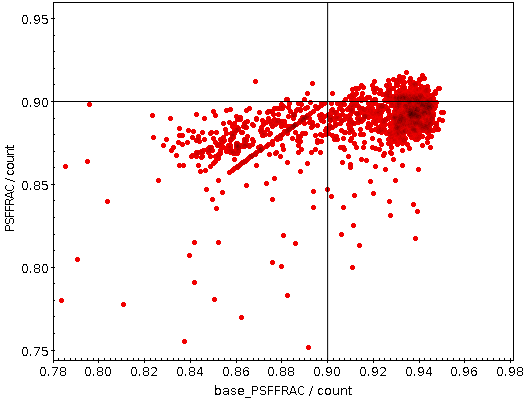

In [6]:
topcat -stilts plot2plane \
   xpix=526 \
   xlabel='base_PSFFRAC / count' \
    ylabel='PSFFRAC / count' \
   xmin=0.78 xmax=0.981 ymin=0.744 ymax=0.96 \
   legend=false \
   fexpr=0.9 antialias=true \
   layer_1=Mark \
      in_1=compare_cscpos.fits \
      x_1=base_PSFFRAC y_1=PSFFRAC \
      shading_1=auto size_1=2 \
   layer_2=Function \
      color_2=black \
   layer_3=Function \
      axis_3=Vertical color_3=black \
   out=base_psf_vs_psf.png 

display < base_psf_vs_psf.png

The interesting thing to take away from this figure is that the PSFFRAC for baseline circular regions is much more spread out compared with the ellipse regions.  The PSFFRAC for the ellipse regions is limited to ~85% to 92% while
the PSFFRAC for the circle region goes from 84% to 96%.


As histograms the data looks like:

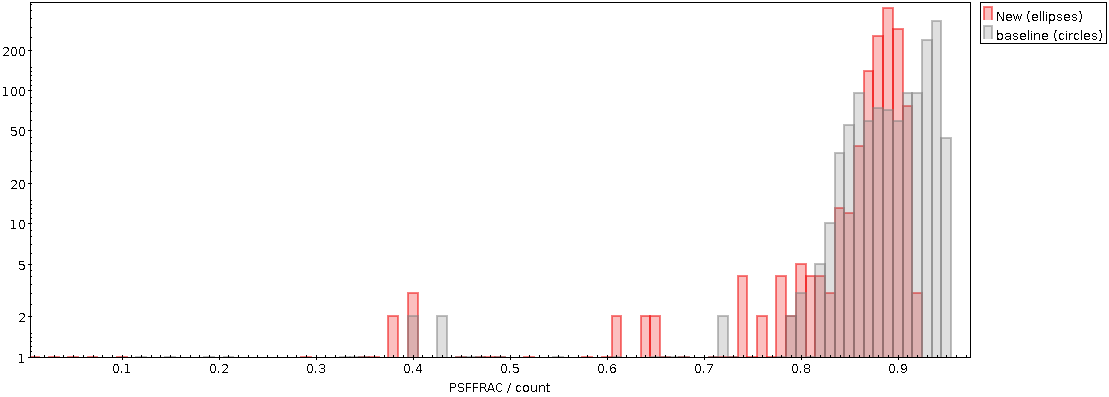

In [7]:
topcat -stilts plot2plane \
   xpix=1109 ypix=397 \
   ylog=true xlabel='PSFFRAC / count' ylabel= \
   xmin=0.005 xmax=0.974 ymin=1 ymax=466 \
   legend=true \
   in=compare_cscpos.fits binsize=-69 phase=0.5 \
   layer_1=Histogram \
      x_1=PSFFRAC \
      leglabel_1='New (ellipses)' \
   layer_2=Histogram \
      x_2=base_PSFFRAC \
      color_2=grey \
      leglabel_2='baseline (circles)' \
   out=psffrac_histogram.png 

display < psffrac_histogram.png

We can now more easily see the narrower distribution of PSFFRAC values for the ellipses.

We can also see that the peak is at 89% rather than 90%.  However, note that the PSF map is based on the medium band CSC data at 1.56keV. These PSFs were simulated for the broad-band at 2.3 keV.  So we indeed expect there to be small diff due to the energies selected.

On the contrary, the PSFFRAC for the circle regions peaks at 94%.  We know that the PSF REEF calibration file is based on a flat detector and these data are for ACIS-I (tilted chips) so that might explain the diff.


Another interesting way to look at the PSFFRAC is vs. off-axis angle, theta

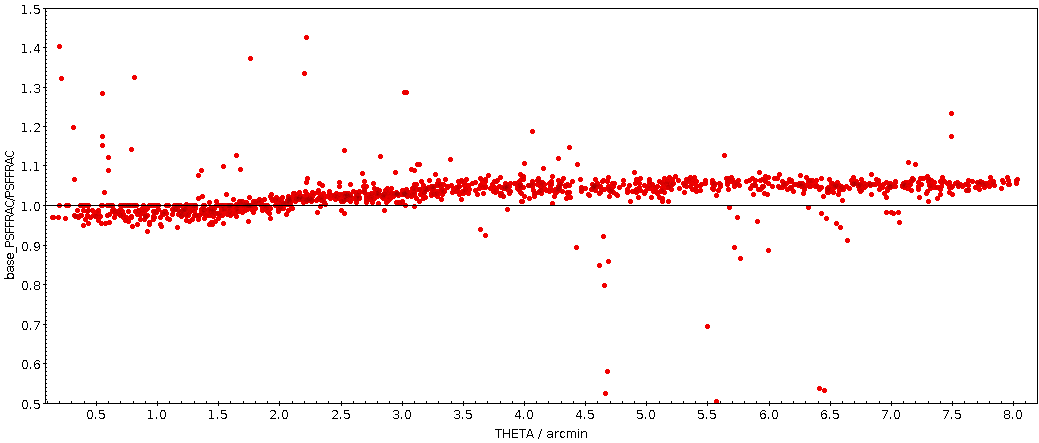

In [8]:
topcat -stilts plot2plane \
   xpix=1039 ypix=443 \
   xlabel='THETA / arcmin' ylabel=base_PSFFRAC/PSFFRAC \
   xmin=0.08 xmax=8.19 ymin=0.5 ymax=1.5 \
   legend=false \
   layer_1=Mark \
      in_1=compare_cscpos.fits \
      x_1=THETA y_1=base_PSFFRAC/PSFFRAC \
      shading_1=auto size_1=2 \
   layer_2=Function \
      fexpr_2=1 color_2=black antialias_2=true \
   out=psffrac_ratio_vs_theta.png 

display < psffrac_ratio_vs_theta.png

Here we plot the ratio of the baseline PSFFRAC for the circular regions divided by the PSFFRAC for the ellipse regions verses theta.

We can see that near on-axis, the PSFFRAC for the circular regions is slightly higher than the PSFFRAC for the ellipse regions.  Around 2arcmin off axis the relationship flips.


## `SRC_SIGNIFICANCE`

The PSFFRAC is an interesting value, but if we are treating it correctly, then it doesn't matter what the value actually is.

What is more interesting is the signal-to-noise or source significance. 

### Compare baseline (circle) to ellipses

First we just plot the baseline `srcflux` regions (circles) with the new ellipse regions we created above.


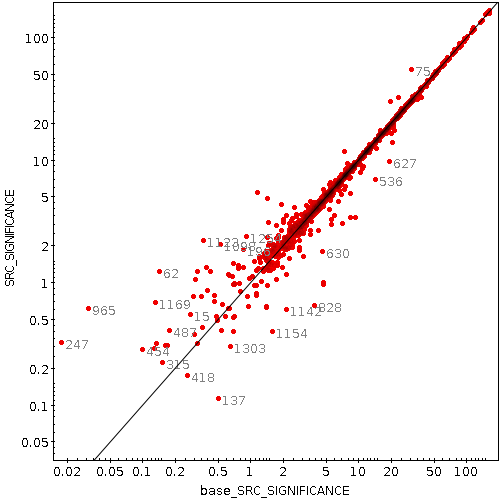

In [9]:
topcat -stilts plot2plane \
   xpix=500 ypix=500 \
   xlog=true ylog=true xlabel=base_SRC_SIGNIFICANCE \
    ylabel=SRC_SIGNIFICANCE \
   xmin=0 xmax=195.1 ymin=0 ymax=195 \
   legend=false \
   in=/proj/sds/Staff/kjg/PSF90/compare_cscpos.fits \
    x=base_SRC_SIGNIFICANCE y=SRC_SIGNIFICANCE \
   layer_1=Mark \
      shading_1=auto size_1=2 \
   layer_2=Label \
      label_2='toString(COMPONENT)' \
      color_2=grey crowdlimit_2=1 \
   layer_3=Function \
      fexpr_3=x color_3=black antialias_3=true \
   out=src_significance.png 

display < src_significance.png

The labels on the data points are the `COMPONENT` values, which is the source ID number.

A few observations

- The two values are generally in excellent agreement.
- The larger deviations between the two values occur at lower significances.


Since the density of the scatter plot could be misleading we also plot a histogram of the ratio of the baseline SRC_SIGNIFICANCE to the new SRC_SIGNIFICANCE


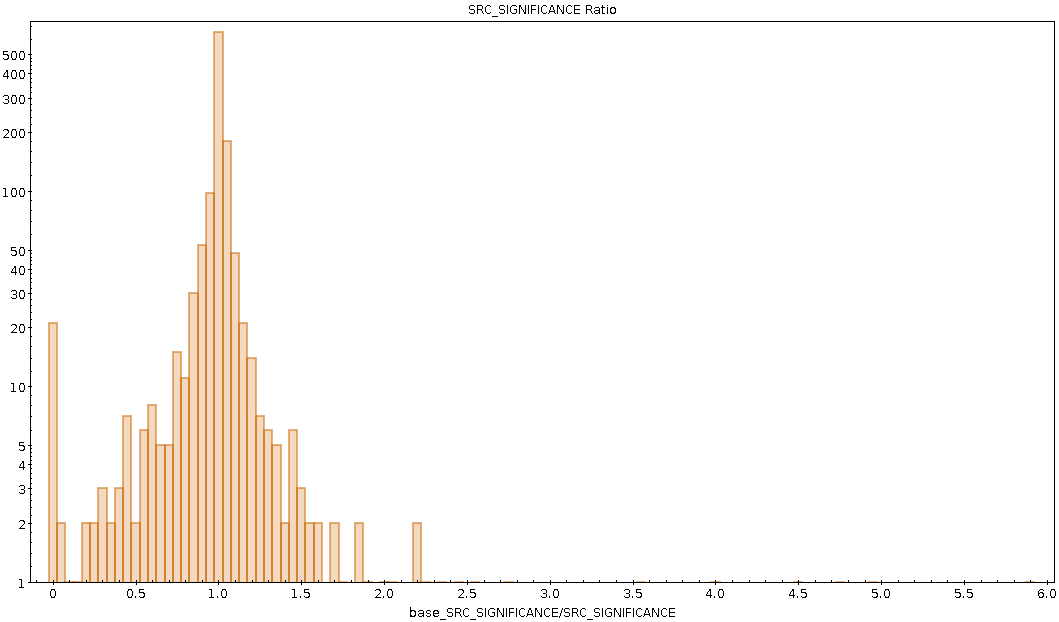

In [15]:
topcat -stilts plot2plane \
   xpix=1059 ypix=622 \
   ylog=true xlabel=base_SRC_SIGNIFICANCE/SRC_SIGNIFICANCE ylabel= \
   xmin=-0.14 xmax=6.04 ymin=1 ymax=745 \
   title='SRC_SIGNIFICANCE Ratio' legend=false \
   layer=Histogram \
      in=/proj/sds/Staff/kjg/PSF90/compare_cscpos.fits \
      x=base_SRC_SIGNIFICANCE/SRC_SIGNIFICANCE \
      color=cc6600 binsize=0.05 phase=0.5 \
   out=src_sig_ratio_histogram.png 

display < src_sig_ratio_histogram.png

Here we can see how strongly peaked the ratio is at 1.0 (note Y-axis is log scale), and that indeed there are really only a few dozen or so outliers out of over 1300 sources

In [16]:
dmlist compare_cscpos.fits counts

1305    


### Ratio vs counts

Another way to explore the SRC_SIGNIFICANCE ratio is to look at it vs COUNTS



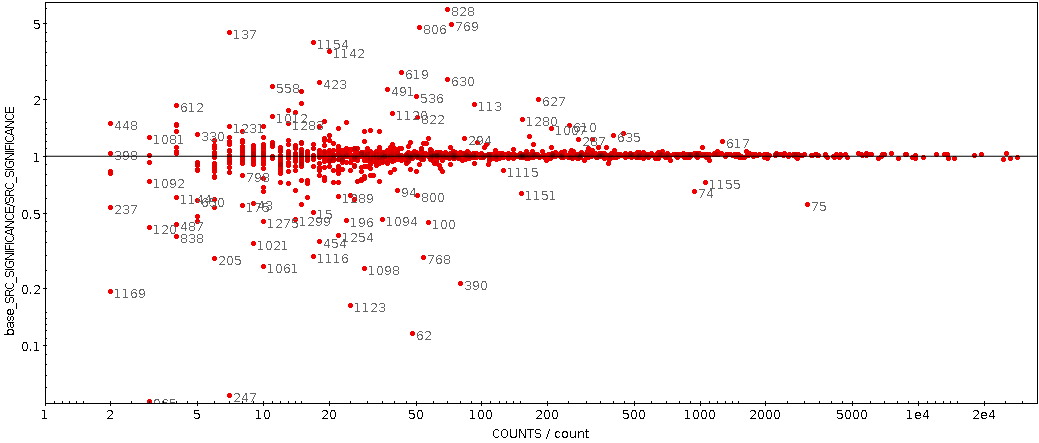

In [10]:
topcat -stilts plot2plane \
   xpix=1039 ypix=443 \
   xlog=true ylog=true xlabel='COUNTS / count' ylabel=base_SRC_SIGNIFICANCE/SRC_SIGNIFICANCE \
   xmin=1 xmax=34835 ymin=0.05 ymax=6.5 \
   legend=false \
   in=compare_cscpos.fits x=COUNTS y=base_SRC_SIGNIFICANCE/SRC_SIGNIFICANCE \
   layer_1=Mark \
      shading_1=auto size_1=2 \
   layer_2=Label \
      label_2='toString(COMPONENT)' \
      color_2=666666 spacing_2=10 crowdlimit_2=1 \
   layer_3=Function \
      fexpr_3=1 color_3=black antialias_3=true \
   out=src_significance_ratio_vs_counts.png 

display < src_significance_ratio_vs_counts.png

This makes it easier to identify the individual outliers.

For references:  

- Values less than 1.0 are because the new SRC_SIGNIFICANCE is higher than the baseline values.
- Values greater than 1.0 are because the baseline SRC_SIGNIFICANCE is higer than the new values.

We will take a look at some of the regions with the largest differences.


### Outliers

#### COMPONENT=828

This source has the largest ratio difference where the basline SRC_SIGNIFICANCE is ~5x the new SRC_SIGNIFCANCE ratio. The source has over 50 counts so this is not an issue of statistical noise.

We start by looking at the source regions


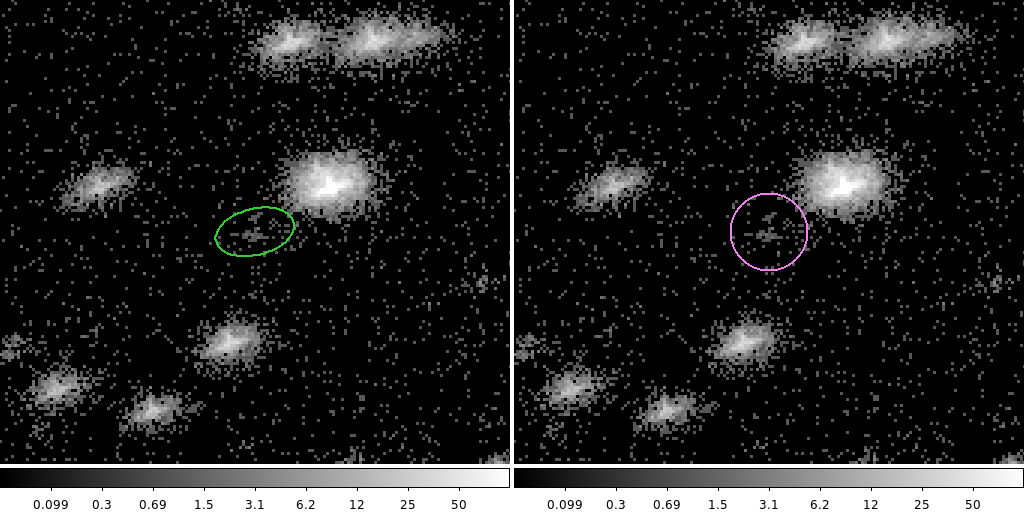

In [42]:
x=$(dmkeypar sf/out_${n}_srcreg.fits x echo+)
y=$(dmkeypar sf/out_${n}_srcreg.fits y echo+)

ds9 acisf4396_broad_thresh.img -pan to $x $y physical \
  -region color limegreen \
  -region load sf/out_${n}_srcreg.fits \
  -region select all -region width 2 -region select none \
  -scale limits 0 100 -scale log -zoom to 3 \
  acisf4396_broad_thresh.img -pan to $x $y physical \
  -region color violet \
  -region load sf_baseline/out_${n}_srcreg.fits \
  -region select all -region width 2 -region select none \
  -width 1024 -height 512 \
  -scale limits 0 100 -scale log -zoom to 3 \
  -saveimage png ds9_${n}_src.png -exit

display < ds9_${n}_src.png

The green ellipse (left) is the new region, and the purple circle (right) is the original, baseline region.

While circle does enclose a few more counts it is not enough to change the SRC_SIGNIFICANCE by a factor of 5.  So let's look at the background regions.  There are nearby sources which may be contaminating the background counts estimate.


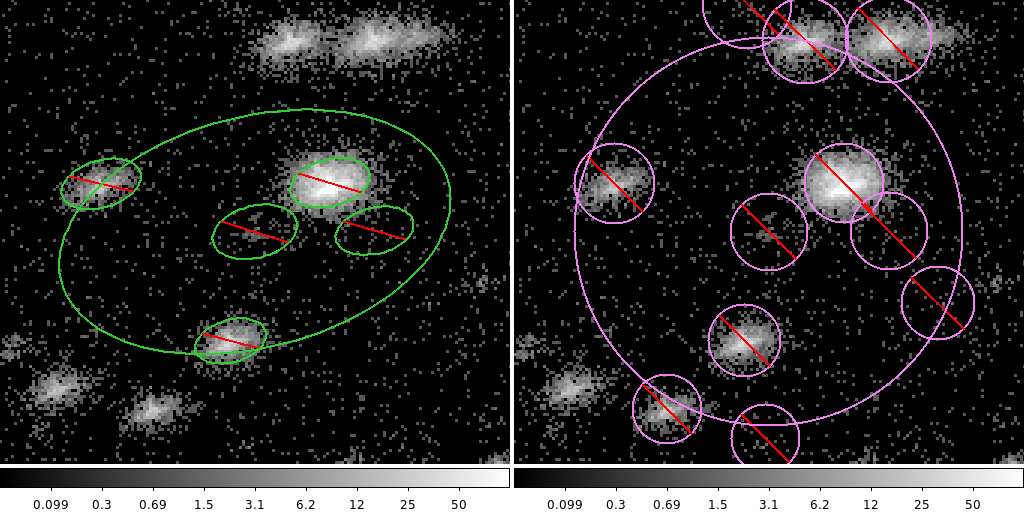

In [40]:
n=0828

x=$(dmkeypar sf/out_${n}_srcreg.fits x echo+)
y=$(dmkeypar sf/out_${n}_srcreg.fits y echo+)

ds9 acisf4396_broad_thresh.img -pan to $x $y physical \
  -region color limegreen \
  -region load sf/out_${n}_bkgreg.fits \
  -region select all -region width 2 -region select none \
  -scale limits 0 100 -scale log -zoom to 3 \
  acisf4396_broad_thresh.img -pan to $x $y physical \
  -region color violet \
  -region load sf_baseline/out_${n}_bkgreg.fits \
  -region select all -region width 2 -region select none \
  -width 1024 -height 512 \
  -scale limits 0 100 -scale log -zoom to 3 \
  -saveimage png ds9_${n}.png -exit

display < ds9_${n}.png

The background ellipse (green, new) and circle (purple, baseline) are now shown with the nearby sources excluded from them (red line though them).  

For the new, green ellipses we see that the bright source just to the upper left of this source has considerable amount of the PSF contaminating the background. Where as more of that source is excluded from the background with the baseline circular regions.

We note that we ran `roi` with the same parameters as are used internally by `srcflux`.  We could choose to increase the size of the excluded sources using the `bkgfactarg`, `bkgfactor`, and `bkgfunction` parameters.  This would help reduce the PSF spill over from bright sources into the background of relatively faint sources like this.


#### COMPONENT=62

COMPONENT=62 is the opposite.  The baseline SRC_SIGNIFICANE is much less than the SRC_SIGNIFICANCE with the ellipses.  Let's take a look

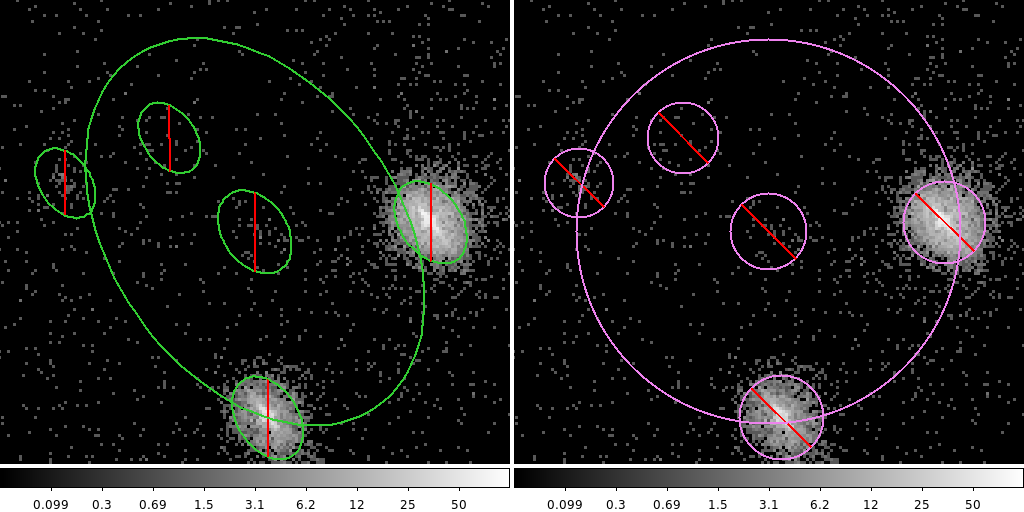

In [43]:
n=0062

x=$(dmkeypar sf/out_${n}_srcreg.fits x echo+)
y=$(dmkeypar sf/out_${n}_srcreg.fits y echo+)

ds9 acisf4396_broad_thresh.img -pan to $x $y physical \
  -region color limegreen \
  -region load sf/out_${n}_bkgreg.fits \
  -region select all -region width 2 -region select none \
  -scale limits 0 100 -scale log -zoom to 3 \
  acisf4396_broad_thresh.img -pan to $x $y physical \
  -region color violet \
  -region load sf_baseline/out_${n}_bkgreg.fits \
  -region select all -region width 2 -region select none \
  -width 1024 -height 512 \
  -scale limits 0 100 -scale log -zoom to 3 \
  -saveimage png ds9_${n}.png -exit

display < ds9_${n}.png

So again we have a well separated faint source with much brighter sources being excluded from the background region.

In this case, the larger background circle is enclosing more of the PSF spill over from the bright sources.

The same comment about `roi` parameters applies.


#### COMPONENT=75

This is a brightest source with significant SRC_SIGNIFICANCE deviation.  Let's take a look. This time we will look at the source region instead of the background


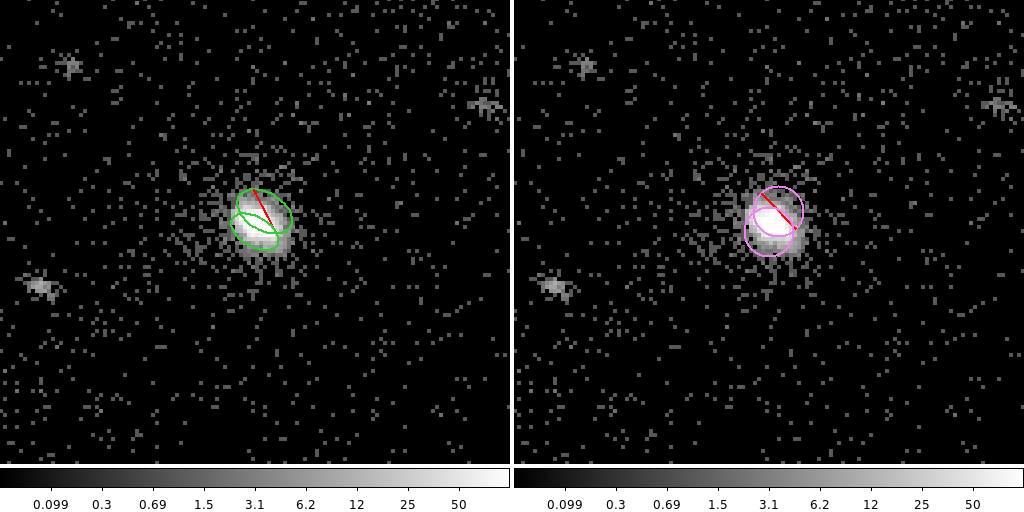

In [46]:
n=0075

x=$(dmkeypar sf/out_${n}_srcreg.fits x echo+)
y=$(dmkeypar sf/out_${n}_srcreg.fits y echo+)

ds9 acisf4396_broad_thresh.img -pan to $x $y physical \
  -region color limegreen \
  -region load sf/out_${n}_srcreg.fits \
  -region select all -region width 2 -region select none \
  -scale limits 0 100 -scale log -zoom to 4 \
  acisf4396_broad_thresh.img -pan to $x $y physical \
  -region color violet \
  -region load sf_baseline/out_${n}_srcreg.fits \
  -region select all -region width 2 -region select none \
  -width 1024 -height 512 \
  -scale limits 0 100 -scale log -zoom to 4 \
  -saveimage png ds9_${n}.png -exit

display < ds9_${n}.png

Okay, so the CSC 2.0 identified two very close sources with overlapping regions.

Reminder: The counts in the overlap area are excluded from both regions -- neither source will use those counts.

Since the overlapping circle excludes a larger number of events, the statistical uncertainty increases which is what is lowering the SRC_SIGNIFICANCE.



> Note: the `rankroi` script could be used to assigned the overlap area to either source using one of these `method`s

>         • max : the region with the largest flux
>         • min : the region with the least flux
>         • bright : the region with the brightest pixel (maximum, maximum pixel value)
>         • faint : the region with the faintest pixel (minimum, maximum pixel value)
>         • big : the region with the largest area
>         • small : the region with the smallest area

From reading the docs, AE takes a different approach.  Instead of excluding the overlap from both sources, it will shrink the polygons until the sources no longer overlap.  This would exclude events from all sides of the sources, not just in the direction of the overlap and seems like overkill, the proverbial throwing baby out with the bath water.

#### COMPONENT=390

Component 390 looks similar to 62 but has even more counts so let's take a look at it's background regions


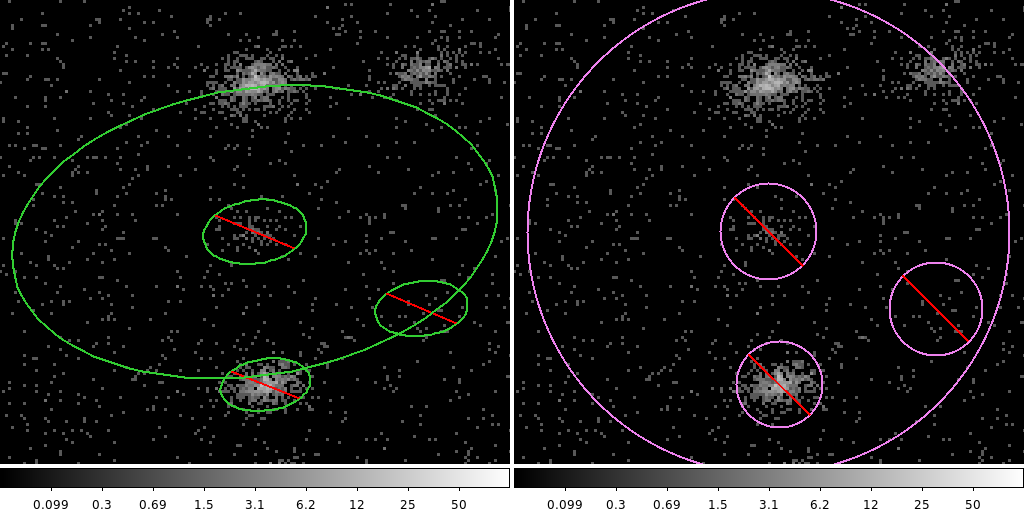

In [48]:
n=0390

x=$(dmkeypar sf/out_${n}_srcreg.fits x echo+)
y=$(dmkeypar sf/out_${n}_srcreg.fits y echo+)

ds9 acisf4396_broad_thresh.img -pan to $x $y physical \
  -region color limegreen \
  -region load sf/out_${n}_bkgreg.fits \
  -region select all -region width 2 -region select none \
  -scale limits 0 100 -scale log -zoom to 3 \
  acisf4396_broad_thresh.img -pan to $x $y physical \
  -region color violet \
  -region load sf_baseline/out_${n}_bkgreg.fits \
  -region select all -region width 2 -region select none \
  -width 1024 -height 512 \
  -scale limits 0 100 -scale log -zoom to 3 \
  -saveimage png ds9_${n}.png -exit

display < ds9_${n}.png

Umm... why aren't those other nearby sources excluded?  That's definitely messing up background.

Oh wait.  We filtered the source list to only include sources insides of 8 arcmin and this source

In [50]:
dmlist compare_cscpos.fits"[component=390][cols theta]" data,clean

#  THETA
 7.9540737543        


is right at edge.  Those other sources have theta greater than 8arcmin so were not included in the processing.  Okay.


## Discussion


So what have we learned?

Overall not that much.  

The "90%" REEFs come with a "wide" distribution (at least for ACIS-I observations).

There are diffs in the output using different regions.  

There are more diffs with smaller number of counts.

There are both improvements and deficiencies using both ellipses and circles.

We may want to improve the background (increase size of excluded regions).

We may want to include `rank_roi` in `srcflux` with **TBD** method.

`topcat` continues to be a fantastic tool when working with tabular data.